In [1]:
%matplotlib notebook
from matplotlib import style

# Import SQL Alchemy
from sqlalchemy import create_engine, inspect, func

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
style.use('fivethirtyeight')


#Flask
from flask import Flask, jsonify




# Import and establish Base for which classes will be constructed 
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session


# Import modules to declare columns and column data types
from sqlalchemy import Column, Integer, String, Float

# Create a connection to a SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [2]:
inspector = inspect(engine)

In [3]:
session = Session(engine)

In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [5]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
inspector.get_table_names()

['measurement', 'station']

In [7]:
data_df = pd.read_sql("SELECT * FROM measurement", connection)
data_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [8]:
data_st = pd.read_sql("SELECT * FROM station", connection)
data_st.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [9]:
# Assign the demographics and measurments class to a variable called `Demographics`
measurements = Base.classes.measurement
Station = Base.classes.station


In [10]:
Station

sqlalchemy.ext.automap.station

In [11]:
#design a query to retrieve the last 12 months of precipitation data
recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [12]:
#calc the date one year from today
one_year_back = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_back)

2016-08-23


In [13]:
#perform a query to retrieve the data and prcp values
prcp_data = session.query(measurements.date, measurements.prcp).\
    filter(measurements.date > one_year_back).\
    order_by(measurements.date).all()

In [14]:
#save as dataframe and set index to date 
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [15]:
prcp_data_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<IPython.core.display.Javascript object>


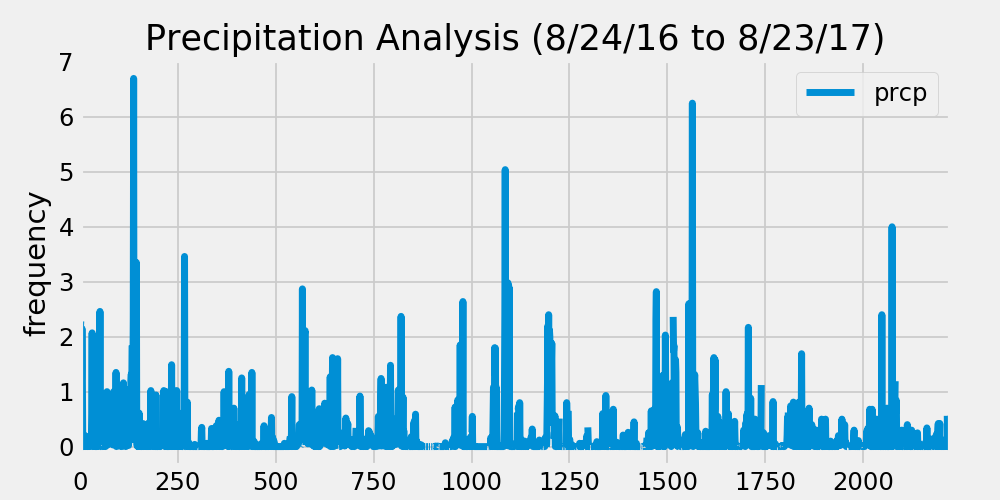

In [16]:
ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()

In [17]:
#Use Pandas to print the summary statistics for the precipitation data.
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# STATION ANALYSIS - Response


In [19]:
# How many stations are available in this dataset?
stat_locations = session.query(measurements).group_by(measurements.station).count()
print("There are {} stations available.".format(stat_locations))
stat_locations

There are 9 stations available.


9

In [21]:
station_counts = session.query(Station.station, func.count(measurements.id)).select_from(measurements).\
    join(Station, measurements.station == Station.station).group_by(Station.station).\
    order_by(func.count(measurements.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [68]:
most_active_station = 'USC00519281'# WAIHEE 837.5, HI US
summary_temps = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [47]:
temp = [func.min(measurements.tobs),
       func.max(measurements.tobs),
       func.avg(measurements.tobs)]
session.query(*temp).filter(measurements.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [54]:
#get temperature data for most active station over final 12 months of data
yearly_temp = session.query(measurements.date, measurements.tobs).filter(measurements.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", measurements.date) >= dt.date(2016, 8, 23)).all()

#input as a data frame
yearly_temp_df = pd.DataFrame(yearly_temp, columns = ['date', 'temperature'])
yearly_temp_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [55]:
#index by date
yearly_temp_df.set_index('date', inplace = True)

<IPython.core.display.Javascript object>


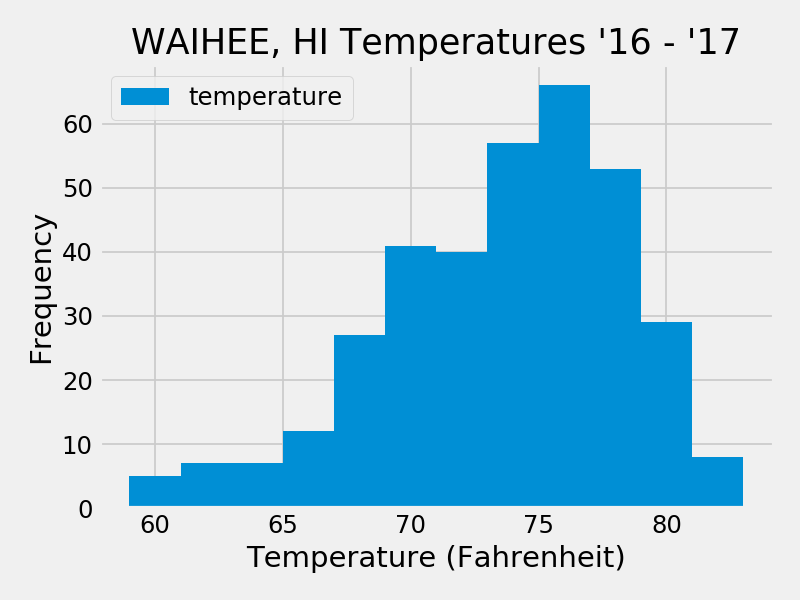

In [69]:
#plot histogram
fig, ax = plt.subplots()
yearly_temp_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("WAIHEE, HI Temperatures '16 - '17")

#save figure
plt.savefig("Images/temp_hist.png")

#plot
plt.tight_layout()
plt.show()

In [37]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [38]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [39]:
# Assign the demographics class to a variable called `Demographics`
measurements = Base.classes.measurement

In [44]:
# To push the objects made and query the server we use a Session object
from sqlalchemy.orm import Session
session = Session(bind=engine)

In [45]:
# Use the session to query Demographics table and display the first 5 locations
for row in session.query(measurements, measurements.date).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x0000027C36C7E438>, '2010-01-01')
(<sqlalchemy.ext.automap.measurement object at 0x0000027C36C7E4A8>, '2010-01-02')
(<sqlalchemy.ext.automap.measurement object at 0x0000027C36C7E518>, '2010-01-03')
(<sqlalchemy.ext.automap.measurement object at 0x0000027C36C7E588>, '2010-01-04')
(<sqlalchemy.ext.automap.measurement object at 0x0000027C36C7E5F8>, '2010-01-06')


2792
